# 数据处理基本流程一览
## 1. 获取数据，并进行清洗

* 加载数据集

Attribute Information:

1. Sequence Name: Accession number for the SWISS-PROT database 
2. mcg: McGeoch's method for signal sequence recognition. 
3. gvh: von Heijne's method for signal sequence recognition. 
4. lip: von Heijne's Signal Peptidase II consensus sequence score. Binary attribute. 
5. chg: Presence of charge on N-terminus of predicted lipoproteins. Binary attribute. 
6. aac: score of discriminant analysis of the amino acid content of outer membrane and periplasmic proteins. 
7. alm1: score of the ALOM membrane spanning region prediction program. 
8. alm2: score of ALOM program after excluding putative cleavable signal regions from the sequence.

In [1]:
%matplotlib inline
import os
import numpy as np
from scipy import stats
import pandas as pd
import sklearn.model_selection as cross_validation  # Use sklearn.cross_validation in old version
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
import sklearn.datasets as datasets
df=pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/yeast/yeast.data',
               header=None,sep='\s+',names=['s_name','mcg','gvh','alm','mit','erl','pox','vac','nuc','target'])
df=df.loc[(df.target=='CYT') |( df.target=='NUC'),'mcg':]
df.head()

,mcg,gvh,alm,mit,erl,pox,vac,nuc,target
3,0.58,0.44,0.57,0.13,0.5,0.0,0.54,0.22,NUC
5,0.51,0.40,0.56,0.17,0.5,0.5,0.49,0.22,CYT
7,0.48,0.45,0.59,0.20,0.5,0.0,0.58,0.34,NUC
9,0.40,0.39,0.60,0.15,0.5,0.0,0.58,0.30,CYT
10,0.43,0.39,0.54,0.21,0.5,0.0,0.53,0.27,NUC


## 2. 划分训练集和测试集，并且特征工程

* 划分训练集和测试集

In [3]:
train_data, test_data, train_target, test_target = cross_validation.train_test_split(
    df.iloc[:,:8], df.iloc[:,8], test_size=0.2, train_size=0.8, random_state=123)   #划分训练集和测试集t

* 极值标准化  
这里有个需要注意的点，test应当按照train来进行预处理,而不能用test的信息进行预处理  
这样做是错误的：
   1. 对train做fit_transfrom,对test做fit_transform
   2. 先对所有数据标准化，然后train_test_split

In [4]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

min_max_scaler.fit(train_data)
train_data_scaled=min_max_scaler.transform(train_data)#fit_transform(train_data)可以两步一起做
test_data_scaled=min_max_scaler.transform(test_data)

## 3. 建模

In [5]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=3)  # 默认欧氏距离
model.fit(train_data, train_target)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [6]:
test_predict = model.predict(test_data)
train_predict=model.predict(train_data)

* 混淆矩阵

In [7]:
import sklearn.metrics as metrics
metrics.confusion_matrix(test_target, test_predict, labels=['CYT','NUC'])#label可以控制显示哪些标签

array([[68, 32],
       [30, 49]], dtype=int64)

In [8]:
print(metrics.classification_report(test_target, test_predict))

             precision    recall  f1-score   support

        CYT       0.69      0.68      0.69       100
        NUC       0.60      0.62      0.61        79

avg / total       0.65      0.65      0.65       179



In [9]:
model.score(test_data, test_target)

0.65363128491620115

- ROC

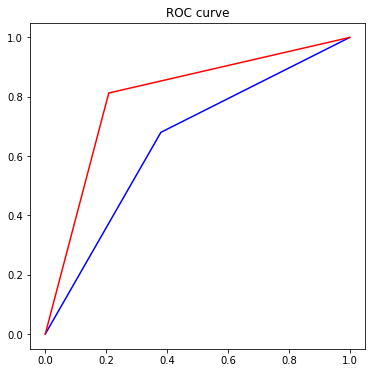

In [10]:
fpr_test, tpr_test, th_test = metrics.roc_curve(test_target=='CYT', test_predict=='CYT')
fpr_train, tpr_train, th_train = metrics.roc_curve(train_target=='CYT', train_predict=='CYT')
plt.figure(figsize=[6,6])
plt.plot(fpr_test, tpr_test, color='blue')
plt.plot(fpr_train, tpr_train, color='red')
plt.title('ROC curve')

* 选择k值

In [11]:
for k in range(1, 15):
    k_model = KNeighborsClassifier(n_neighbors=k)
    k_model.fit(train_data, train_target.values.flatten())
    score = k_model.score(test_data, test_target)
    print(k, '\t', score)

1 	 0.614525139665
2 	 0.603351955307
3 	 0.653631284916
4 	 0.620111731844
5 	 0.63687150838
6 	 0.648044692737
7 	 0.653631284916
8 	 0.648044692737
9 	 0.664804469274
10 	 0.642458100559
11 	 0.653631284916
12 	 0.675977653631
13 	 0.653631284916
14 	 0.664804469274


* 交叉验证选择k值

In [12]:
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import KFold

n_samples = len(train_data)
kf = KFold(n_splits=3) # Set parameter to 'n=n_samples, n_folds=3' in old version
grid = ParameterGrid({'n_neighbors':[range(4,10)]})
estimator = KNeighborsClassifier()
gridSearchCV = GridSearchCV(estimator, grid, cv=3)
gridSearchCV.fit(train_data, train_target.values.flatten())
# gridSearchCV.grid_scores_  # Use it in old version
gridSearchCV.cv_results_

{'mean_fit_time': array([ 0.00156093,  0.00183328,  0.        ,  0.00520261,  0.        ,  0.        ]),
 'mean_score_time': array([ 0.00358613,  0.00277567,  0.00521509,  0.        ,  0.00523996,  0.        ]),
 'mean_test_score': array([ 0.6058906 ,  0.6115007 ,  0.61290323,  0.62412342,  0.61570827,
         0.6171108 ]),
 'mean_train_score': array([ 0.73494029,  0.74264927,  0.71388913,  0.72792127,  0.70758367,
         0.71390093]),
 'param_n_neighbors': masked_array(data = [4 5 6 7 8 9],
              mask = [False False False False False False],
        fill_value = ?),
 'params': [{'n_neighbors': 4},
  {'n_neighbors': 5},
  {'n_neighbors': 6},
  {'n_neighbors': 7},
  {'n_neighbors': 8},
  {'n_neighbors': 9}],
 'rank_test_score': array([6, 5, 4, 1, 3, 2]),
 'split0_test_score': array([ 0.59243697,  0.62184874,  0.62184874,  0.62184874,  0.62184874,
         0.61344538]),
 'split0_train_score': array([ 0.74526316,  0.75368421,  0.72210526,  0.74315789,  0.72210526,
         0.73

In [13]:
gridSearchCV.best_params_

{'n_neighbors': 7}

In [14]:
best = gridSearchCV.best_estimator_ 
best.score(test_data, test_target)

0.65363128491620115